In [1]:
import numpy as np
import sys
import os
import glob
import importlib
import math as m
import pickle as pickle
import seaborn as sns
import statistics
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import matplotlib # produce matlab-style plots
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
matplotlib.rc('font',**{'size':20}) # increase font size on plots
matplotlib.rc('text',usetex=False) # use LaTeX to render symbols
matplotlib.rc('animation',html='html5') # render animation
font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'
prop_cycle = plt.rcParams['axes.prop_cycle']
python_colors = prop_cycle.by_key()['color'] # python default color cycle

# auto reload modules
%load_ext autoreload
%autoreload 2
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *
# DATA_PATH = 'C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion' #change this for your computer

In [32]:
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *

In [33]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [104]:
# with open('multimodal_data.pkl', 'wb') as file:
#     pickle.dump(ALLdata, file)

# Load the array from the file
with open('multimodal_data.pkl', 'rb') as file:
    Rs,Ds,Us,U0s,U1s,Ys,rs,ds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd = pickle.load(file)

In [105]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
conditions = ['0','0.25','0.5','0.75','1']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


# Time Domain

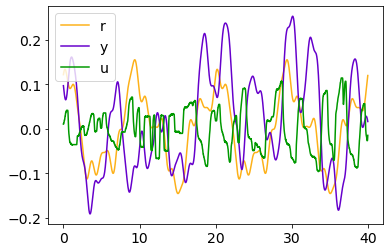

In [86]:
# example trial
plt.plot(t,rs[0,0,-1,:],label = 'r',color = colors['r'])
plt.plot(t,ys[0,0,-1,:],label = 'y',color = colors['y'])
plt.plot(t,us[0,0,-1,:],label = 'u',color = colors['u'])
plt.legend()
plt.show()

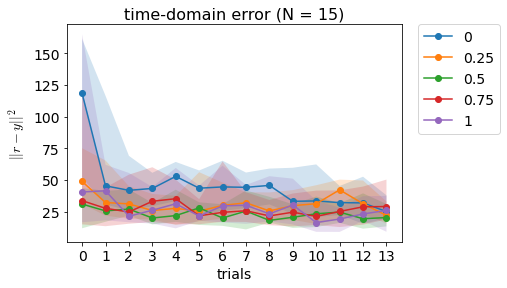

In [87]:
fig,ax = plt.subplots(sharex=True,figsize=(6,4))
x = np.arange(0,trial_num,1)
for iC, condition in enumerate(conditions):
    mean, quantile25, quantile50, quantile75 = mean_and_interquartile(errors[:,iC,:], axis = 0)
    ax.plot(x, quantile50,'-o',label = condition)
    ax.fill_between(x, quantile25, quantile75, alpha=0.2)
ax.set_xticks(x)
ax.set_title('time-domain error (N = 15)')
ax.set_xlabel('trials')
ax.set_ylabel(r'$||r-y||^2$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Human model H

In [62]:
Hs = -Us / Ys  #-inp/out
Hs.shape

(15, 5, 14, 2400)

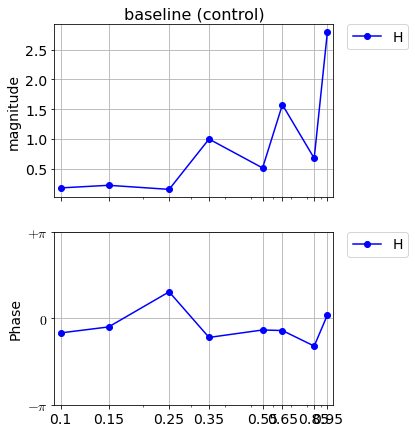

In [63]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi,np.pi)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
sub = 0
cond = 0
trial = 0

fig,axs = plt.subplots(2,1,sharex=True,figsize=(5,7))
ax = axs[0]
ax.plot(freqs,np.abs(Hs[sub,cond,trial,IX]),'-o',color= 'blue',label = 'H')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
ax.set_ylabel('magnitude')
ax.set_title('baseline (control)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax = axs[1]
ax.plot(freqs,np.angle(Hs[sub,cond,trial,IX]),'-o',color= 'blue',label = 'H')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

# FF and FB

In [106]:
def FF_FB(Tur,Tud):
    B = - (1 / M) * (Tud / (1+ Tud)) 
    F = (1 + B * M)*Tur - B
    return F,B

In [108]:
F = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
B = np.zeros(Tur.shape, dtype=complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        for i in range(trial_num//2):
            F[sub,cond,i],B[sub,cond,i] = FF_FB(Tur[sub,cond,i],Tud[sub,cond,i])
print(F.shape) # subject x condition x trial//2 x stimulated freqs
print(B.shape)

(15, 5, 7, 8)
(15, 5, 7, 8)


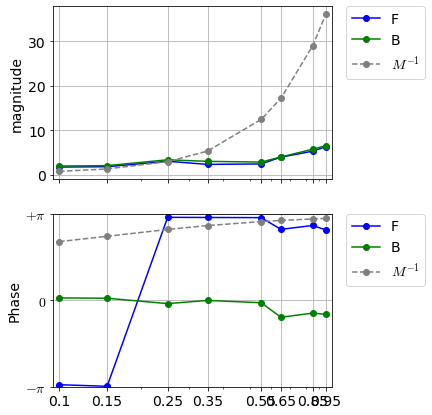

In [113]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi,np.pi)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
sub = 0
cond = 0
trial = -1

fig,axs = plt.subplots(2,1,sharex=True,figsize=(5,7))
ax = axs[0]
ax.plot(freqs,np.abs(F[sub,cond,trial]),'-o',color= 'blue',label = 'F')
ax.plot(freqs,np.abs(B[sub,cond,trial]),'-o',color= 'green',label = 'B')
ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax = axs[1]
ax.plot(freqs,np.angle(F[sub,cond,trial]),'-o',color= 'blue',label = 'F')
ax.plot(freqs,np.angle(B[sub,cond,trial]),'-o',color= 'green',label = 'B')
ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()